# CoordConv experiments - Supervised Coordinate Regression
*Notebooks to reproduce [CoordConv paper](https://arxiv.org/abs/1807.03247) using PyTorch framework and [Ignite](https://github.com/pytorch/ignite)*

This notebook describes coordinate regression task: given an input image containing a single white pixel, network need to output its coordinates.
We compare classical deconvolutional network and a network with CoordConv.

Implementation of CoordConv is taken from [mkocabas/CoordConv-pytorch](https://github.com/mkocabas/CoordConv-pytorch) (thanks to @mkocabas)

## 0. Not-so-Clevr toy dataset

In [1]:
from notsoclevr import NotSoClevr


ds = NotSoClevr()

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

def to_img(t):
    return 255 * t.numpy()[0, :, :]

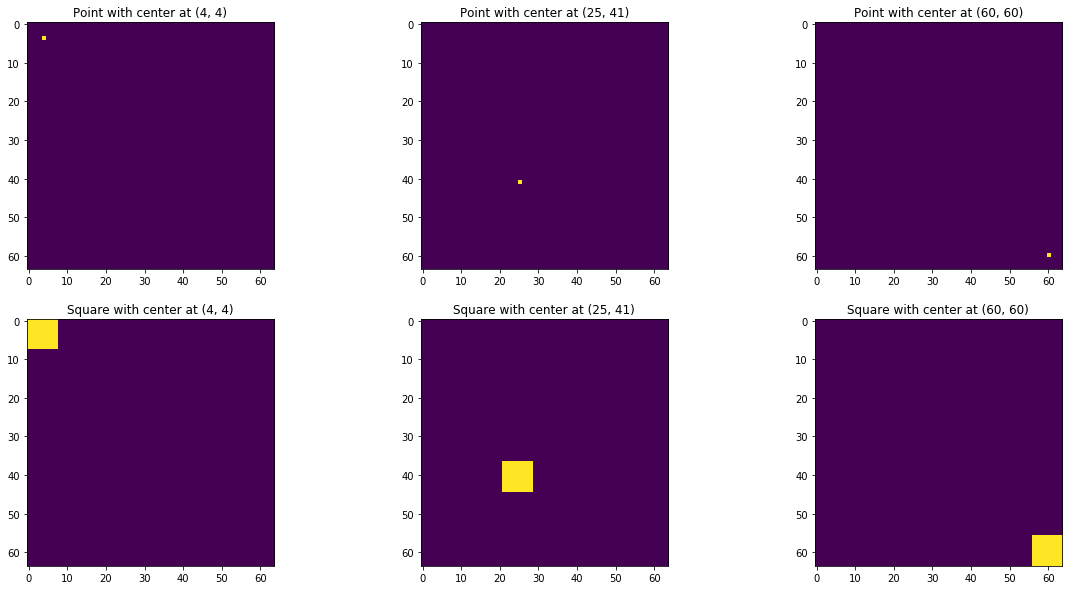

In [3]:
plt.figure(figsize=(20, 10))

c, p, im = ds[0]
plt.subplot(231)
plt.title("Point with center at {}".format(c))
plt.imshow(to_img(p))
plt.subplot(234)
plt.title("Square with center at {}".format(c))
plt.imshow(to_img(im))

c, p, im = ds[1234]
plt.subplot(232)
plt.title("Point with center at {}".format(c))
plt.imshow(to_img(p))
plt.subplot(235)
plt.title("Square with center at {}".format(c))
plt.imshow(to_img(im))

c, p, im = ds[-1]
plt.subplot(233)
plt.title("Point with center at {}".format(c))
plt.imshow(to_img(p))
plt.subplot(236)
plt.title("Square with center at {}".format(c))
plt.imshow(to_img(im))

Train/Test splits:
- random split
- quadrant split

In [4]:
import torch

seed = 12
_ = torch.manual_seed(seed)

In [5]:
size = len(ds)

random_indices = torch.randperm(size)
train_split = int(0.75 * size)

train_random_indices = random_indices[:train_split]
test_random_indices = random_indices[train_split:]

train_random_indices.shape, test_random_indices.shape

(torch.Size([2436]), torch.Size([813]))

In [6]:
train_quadrant_indices = []
test_quadrant_indices = []

for i, (c, p, im) in enumerate(ds):
    if c[0] > ds.canvas_size * 0.5 and \
        c[1] > ds.canvas_size * 0.5:
        test_quadrant_indices.append(i)
    else:
        train_quadrant_indices.append(i)

train_quadrant_indices = torch.tensor(train_quadrant_indices)
test_quadrant_indices = torch.tensor(test_quadrant_indices)


index = 0
sum_train_random_points = ds[train_random_indices[index]][1]
for index in range(1, len(train_random_indices)):
    sum_train_random_points += ds[train_random_indices[index]][1]
    
index = 0
sum_test_random_points = ds[test_random_indices[index]][1]
for index in range(1, len(test_random_indices)):
    sum_test_random_points += ds[test_random_indices[index]][1]
    
index = 0
sum_train_quad_points = ds[train_quadrant_indices[index]][1]
for index in range(1, len(train_quadrant_indices)):
    sum_train_quad_points += ds[train_quadrant_indices[index]][1]
    
index = 0
sum_test_quad_points = ds[test_quadrant_indices[index]][1]
for index in range(1, len(test_quadrant_indices)):
    sum_test_quad_points += ds[test_quadrant_indices[index]][1]

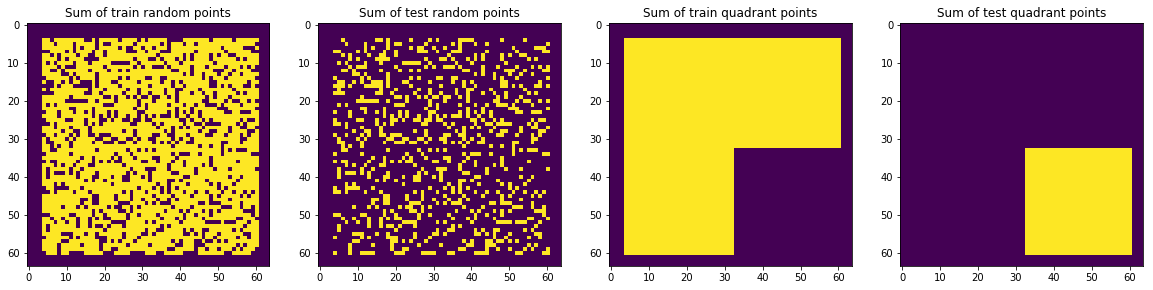

In [7]:
plt.figure(figsize=(20, 10))

plt.subplot(141)
plt.title("Sum of train random points")
plt.imshow(to_img(sum_train_random_points))

plt.subplot(142)
plt.title("Sum of test random points")
plt.imshow(to_img(sum_test_random_points))

plt.subplot(143)
plt.title("Sum of train quadrant points")
plt.imshow(to_img(sum_train_quad_points))

plt.subplot(144)
plt.title("Sum of test quadrant points")
plt.imshow(to_img(sum_test_quad_points))

## 1. Supervised Coordinate Regression

Given an input image containing a single white pixel, network need to output its coordinatesan `(x, y)`.

### Model with convolutions

Following S3 of the paper, we defines a fully-convolutional with global pooling network which is goog for quadrant split

In [8]:
import torch.nn as nn


class ClassicConvNet(nn.Module):
    
    def __init__(self):
        super(ClassicConvNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(5, 5), stride=2, padding=3),
            nn.ReLU(),            
            nn.Conv2d(16, 16, kernel_size=(1, 1)),
            nn.ReLU(),            
            nn.BatchNorm2d(16),            
            nn.Conv2d(16, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),            
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),            
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),            
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 2, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),            
        )
        
    def forward(self, x):
        n, *_ = x.shape
        return self.net(x).view(n, -1)

#### Quadrant train/test split

In [46]:
x = torch.rand(4, 1, 64, 64)

conv_net = ClassicConvNet()
y = conv_net(x)
y.shape

torch.Size([4, 2])

In [9]:
from utils import TransformedDataset


def xy_transform(dp):
    c, p, _ = dp
    return p.type(torch.float32), torch.tensor(c, dtype=torch.float32)


t_ds = TransformedDataset(ds, xy_transform=xy_transform)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

batch_size = 64
num_workers = 4

train_ds = Subset(t_ds, indices=train_quadrant_indices)
train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory='cuda' in device)

test_ds = Subset(t_ds, indices=test_quadrant_indices)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory='cuda' in device)

We are using [Ignite](https://github.com/pytorch/ignite) to train the network

In [12]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss

In [51]:
loss = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(conv_net.parameters(), lr=0.003, weight_decay=0.0001)


metrics = {
    'avg_loss': Loss(loss),
}


trainer = create_supervised_trainer(conv_net, optimizer=optimizer, loss_fn=loss, device=device)
evaluator = create_supervised_evaluator(conv_net, metrics=metrics, device=device)

In [52]:
from ignite.engine import Events

log_interval = 10

        
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    if engine.state.epoch % log_interval != 0:
        return
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_loss = metrics['avg_loss']
    print("Training Results - Epoch: {}  Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    if engine.state.epoch % log_interval != 0:
        return    
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    avg_loss = metrics['avg_loss']
    print("Validation Results - Epoch: {} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_loss))

In [53]:
from torch.optim.lr_scheduler import StepLR

lr_scheduler = StepLR(optimizer, step_size=40, gamma=0.9)


@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])

In [54]:
trainer.run(train_loader, max_epochs=200)

Training Results - Epoch: 10  Avg loss: 1.77
Validation Results - Epoch: 10 Avg loss: 12.73
Training Results - Epoch: 20  Avg loss: 0.62
Validation Results - Epoch: 20 Avg loss: 11.29
Training Results - Epoch: 30  Avg loss: 0.70
Validation Results - Epoch: 30 Avg loss: 8.05
Training Results - Epoch: 40  Avg loss: 1.19
Validation Results - Epoch: 40 Avg loss: 8.72
Training Results - Epoch: 50  Avg loss: 0.14
Validation Results - Epoch: 50 Avg loss: 7.92
Training Results - Epoch: 60  Avg loss: 0.09
Validation Results - Epoch: 60 Avg loss: 7.70
Training Results - Epoch: 70  Avg loss: 0.81
Validation Results - Epoch: 70 Avg loss: 6.88
Training Results - Epoch: 80  Avg loss: 3513.78
Validation Results - Epoch: 80 Avg loss: 3564.99
Training Results - Epoch: 90  Avg loss: 0.67
Validation Results - Epoch: 90 Avg loss: 5.82
Training Results - Epoch: 100  Avg loss: 96.30
Validation Results - Epoch: 100 Avg loss: 102.31
Training Results - Epoch: 110  Avg loss: 0.47
Validation Results - Epoch: 110

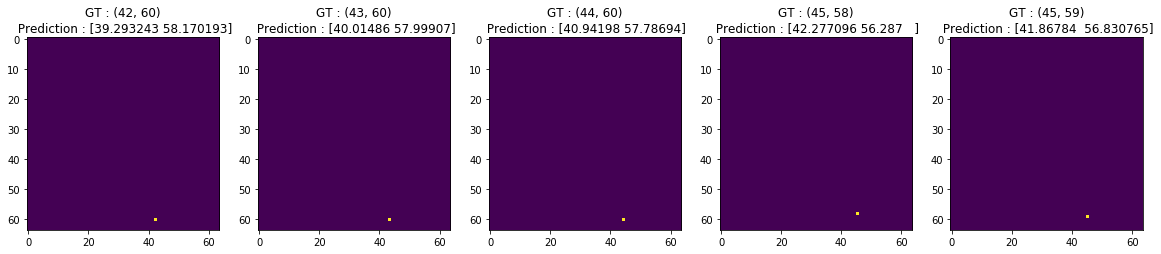

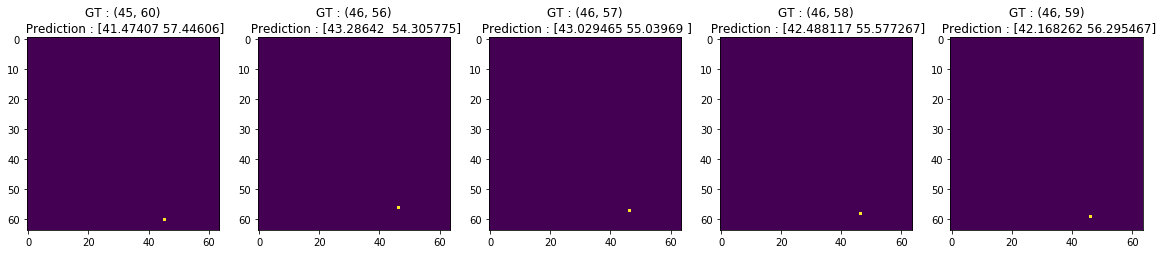

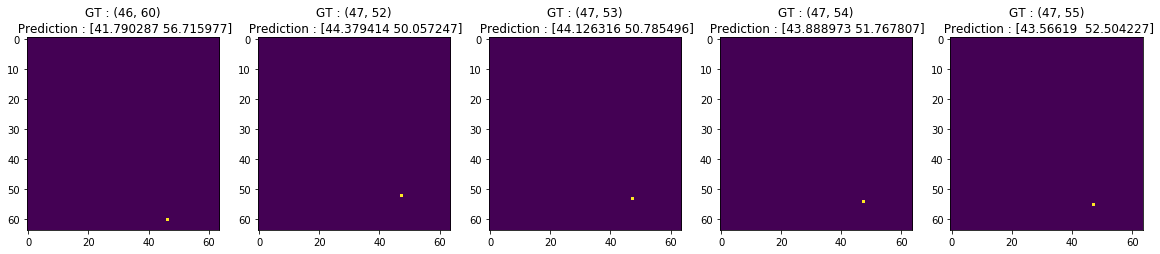

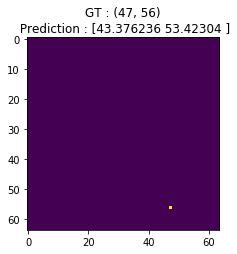

In [87]:
from torch.nn import functional as F

conv_net.eval()

n_cols = 5
counter = 0
max_counter = 15
for i in test_quadrant_indices:
    dp = ds[i]
    x = dp[1].type(torch.float32).unsqueeze(0).to(device)
    y = conv_net(x)
    y_pred = y[0].detach().cpu()
    y_true = torch.tensor(dp[0], dtype=torch.float32)
    
    err = ((y_true - y_pred)**2).sum()
    if err.item() > 10.0:
        if counter % n_cols == 0:
            plt.figure(figsize=(20, 10))
            max_counter -= counter
            counter = 0
        
        plt.subplot(1, n_cols, counter + 1)
        plt.title("GT : {}\n Prediction : {}".format(dp[0], y_pred.numpy()))
        plt.imshow(to_img(dp[1]))
        counter += 1
        
    if max_counter == 0:
        break

### Model with CoordConv

In [13]:
from coord_conv import CoordConv

In [32]:
import torch.nn as nn
from torch.nn import functional as F


class CoordConvNet(nn.Module):
        
    def __init__(self, fs=2, c=1):
        super(CoordConvNet, self).__init__()        
        self.net = nn.Sequential(
            CoordConv(1, 8, kernel_size=(1, 1)),
            nn.ReLU(),            
            nn.Conv2d(8, 8, kernel_size=(1, 1)),
            nn.ReLU(),            
            nn.Conv2d(8, 8, kernel_size=(1, 1)),
            nn.ReLU(),
            
            nn.Conv2d(8, 8, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 2, kernel_size=(3, 3), padding=1),
            nn.AdaptiveAvgPool2d(1),            
        )
        
    def forward(self, x):
        n, *_ = x.shape
        return self.net(x).view(n, -1)

#### Quadrant train/test split

In [41]:
x = torch.rand(4, 1, 64, 64)

coord_conv_net = CoordConvNet()
y = coord_conv_net(x)
y.shape

torch.Size([4, 2])

In [42]:
loss = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(coord_conv_net.parameters(), lr=0.01, weight_decay=0.001)


metrics = {
    'avg_loss': Loss(loss),
}


trainer = create_supervised_trainer(coord_conv_net, optimizer=optimizer, loss_fn=loss, device=device)
evaluator = create_supervised_evaluator(coord_conv_net, metrics=metrics, device=device)

In [43]:
from ignite.engine import Events

log_interval = 10

        
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    if engine.state.epoch % log_interval != 0:
        return
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_loss = metrics['avg_loss']
    print("Training Results - Epoch: {}  Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    if engine.state.epoch % log_interval != 0:
        return    
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    avg_loss = metrics['avg_loss']
    print("Validation Results - Epoch: {} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_loss))

In [44]:
from torch.optim.lr_scheduler import StepLR

lr_scheduler = StepLR(optimizer, step_size=40, gamma=0.9)


@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])

In [45]:
trainer.run(train_loader, max_epochs=200)

Training Results - Epoch: 10  Avg loss: 249.16
Validation Results - Epoch: 10 Avg loss: 387.93
Training Results - Epoch: 20  Avg loss: 248.05
Validation Results - Epoch: 20 Avg loss: 431.93
Training Results - Epoch: 30  Avg loss: 248.97
Validation Results - Epoch: 30 Avg loss: 423.74
Training Results - Epoch: 40  Avg loss: 249.13
Validation Results - Epoch: 40 Avg loss: 423.70
Training Results - Epoch: 50  Avg loss: 248.34
Validation Results - Epoch: 50 Avg loss: 457.67
Training Results - Epoch: 60  Avg loss: 247.86
Validation Results - Epoch: 60 Avg loss: 430.73
Training Results - Epoch: 70  Avg loss: 248.62
Validation Results - Epoch: 70 Avg loss: 463.35
Training Results - Epoch: 80  Avg loss: 249.14
Validation Results - Epoch: 80 Avg loss: 402.73
Training Results - Epoch: 90  Avg loss: 168.69
Validation Results - Epoch: 90 Avg loss: 91.23
Training Results - Epoch: 100  Avg loss: 168.09
Validation Results - Epoch: 100 Avg loss: 62.82
Training Results - Epoch: 110  Avg loss: 168.03
Va

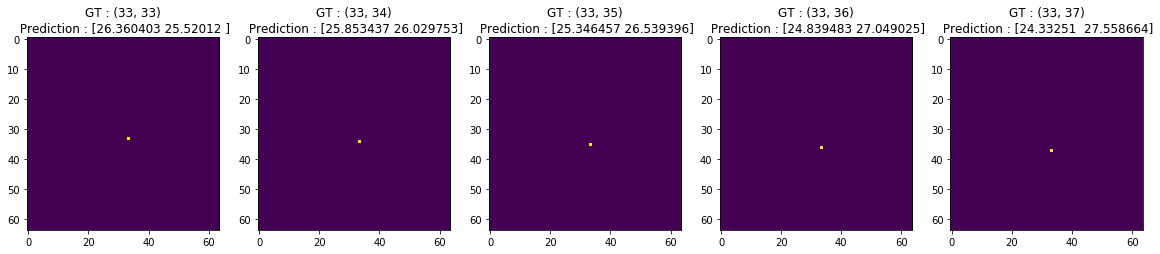

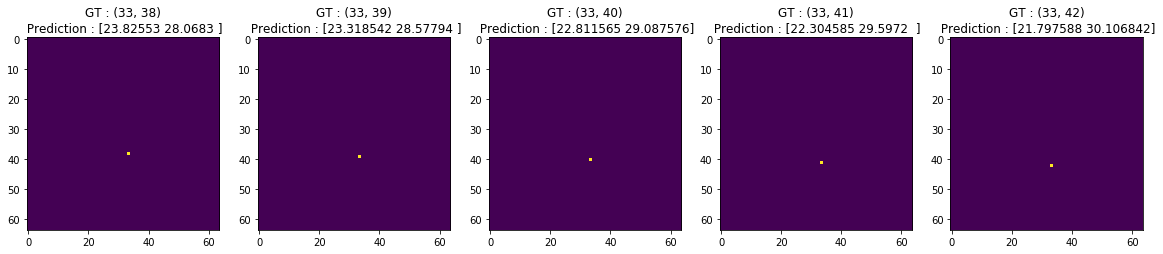

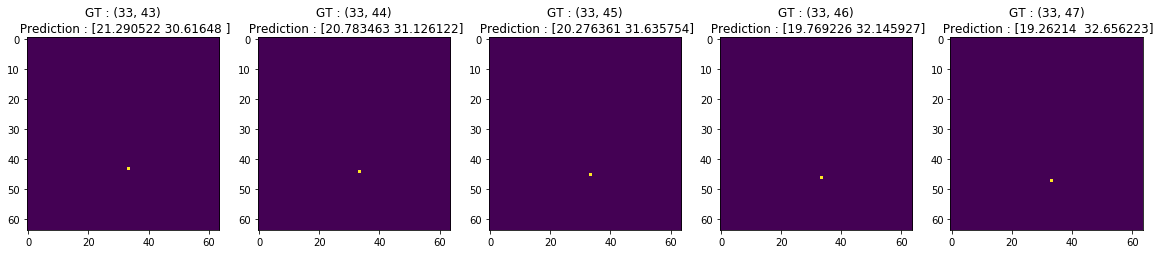

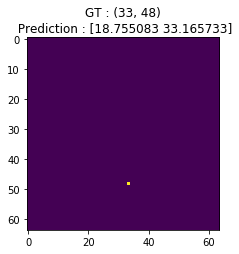

In [46]:
from torch.nn import functional as F

coord_conv_net.eval()

n_cols = 5
counter = 0
max_counter = 15
for i in test_quadrant_indices:
    dp = ds[i]
    x = dp[1].type(torch.float32).unsqueeze(0).to(device)
    y = coord_conv_net(x)
    y_pred = y[0].detach().cpu()
    y_true = torch.tensor(dp[0], dtype=torch.float32)
    
    err = ((y_true - y_pred)**2).sum()
    if err.item() > 10.0:
        if counter % n_cols == 0:
            plt.figure(figsize=(20, 10))
            max_counter -= counter
            counter = 0
        
        plt.subplot(1, n_cols, counter + 1)
        plt.title("GT : {}\n Prediction : {}".format(dp[0], y_pred.numpy()))
        plt.imshow(to_img(dp[1]))
        counter += 1
        
    if max_counter == 0:
        break